In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from benchmark import models
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import numpy as np
import re
import logging
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.signal

In [3]:
from benchmark import plots

In [4]:
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette("colorblind")

In [5]:
def load_best_model(model_cls, weights, version):
    """
    Determines the model with lowest validation loss from the csv logs and loads it

    :param model_cls: Class of the lightning module to load
    :param weights: Path to weights as in cmd arguments
    :param version: String of version file
    :return: Instance of lightning module that was loaded from the best checkpoint
    """
    metrics = pd.read_csv(weights / version / "metrics.csv")

    idx = np.nanargmin(metrics["val_loss"])
    min_row = metrics.iloc[idx]

    checkpoint = f"epoch={min_row['epoch']:.0f}-step={min_row['step']:.0f}.ckpt"

    version_id = version.split("_")[-1]
    version_str = f"{version_id}_{version_id}"

    checkpoint_path = (
        weights.parent
        / f"{weights.name}_{weights.name}"
        / version_str
        / "checkpoints"
        / checkpoint
    )

    return model_cls.load_from_checkpoint(checkpoint_path)

In [6]:
# Load data

target = "geofon"
source = "geofon"

data_kwargs = dict(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")

data = sbd.GEOFON(**data_kwargs)

data = data.dev()  # Intepretation on dev set

<ipython-input-6-8dc9c1b7b55b>:8: DtypeWarning: Columns (38,49,51) have mixed types.Specify dtype option on import or set low_memory=False.
  data = sbd.GEOFON(**data_kwargs)


In [544]:
# Load models
basepath = Path("weights")

basicphaseae = load_best_model(models.BasicPhaseAELit, basepath / f"{source}_basicphaseae", "version_0")
cred = load_best_model(models.CREDLit, basepath / f"{source}_cred", "version_0")
dpp_p = load_best_model(models.DPPPickerLit, basepath / f"{source}_dpppickerp", "version_0")
try:
    dpp_s = load_best_model(models.DPPPickerLit, basepath / f"{source}_dpppickers", "version_0")
except FileNotFoundError:
    pass
eqtransformer = load_best_model(models.EQTransformerLit, basepath / f"{source}_eqtransformer", "version_0")
gpd = load_best_model(models.GPDLit, basepath / f"{source}_gpd", "version_0")
gpdpick = load_best_model(models.GPDLit, basepath / f"{source}_gpdpick", "version_0")
phasenet = load_best_model(models.PhaseNetLit, basepath / f"{source}_phasenet", "version_0")

In [545]:
# Move models to GPU
basicphaseae.cuda()
cred.cuda()
dpp_p.cuda()
dpp_s.cuda()
eqtransformer.cuda()
gpd.cuda()
gpdpick.cuda()
phasenet.cuda();

In [546]:
# Load targets and create generators
# targetpath = Path("targets") / target / "task1.csv"
targetpath = Path("targets") / target / "task23.csv"

task_targets = pd.read_csv(targetpath)
task_targets = task_targets[task_targets["trace_split"] == "dev"]

basicphaseae_generator = sbg.SteeredGenerator(data, task_targets)
basicphaseae_generator.add_augmentations(basicphaseae.get_eval_augmentations())
cred_generator = sbg.SteeredGenerator(data, task_targets)
cred_generator.add_augmentations(cred.get_eval_augmentations())
dpp_generator = sbg.SteeredGenerator(data, task_targets)
dpp_generator.add_augmentations(dpp_p.get_eval_augmentations())
eqtransformer_generator = sbg.SteeredGenerator(data, task_targets)
eqtransformer_generator.add_augmentations(eqtransformer.get_eval_augmentations())
gpd_generator = sbg.SteeredGenerator(data, task_targets)
gpd_generator.add_augmentations(gpd.get_eval_augmentations())
phasenet_generator = sbg.SteeredGenerator(data, task_targets)
phasenet_generator.add_augmentations(phasenet.get_eval_augmentations())

In [547]:
color_dict = {"det": "C3", "P": "C4", "S": "C5"}

In [548]:
def basicphaseae_plot(idx, ax):
    batch = basicphaseae_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]
    
    re = torch.zeros(x.shape[:2] + (7, 600), dtype=x.dtype)
    for i, start in enumerate(range(0, 2401, 400)):
        re[:, :, i] = x[:, :, start:start + 600]
    
    x = re
    x = x.permute(0, 2, 1, 3)  # --> (batch, windows, channels, samples)
    shape_save = x.shape
    x = x.reshape(-1, 3, 600)  # --> (batch * windows, channels, samples)
    pred = basicphaseae(x.to(basicphaseae.device))
    pred = pred.reshape(
        shape_save[:2] + (3, 600)
    )  # --> (batch, window, channels, samples)
    full_pred = torch.zeros((pred.shape[0], pred.shape[2], 3000))
    for i, start in enumerate(range(0, 2401, 400)):
        if start == 0:
            # Use full window (for start==0, the end will be overwritten)
            full_pred[:, :, start:start + 600] = pred[:, i]
        else:
            full_pred[:, :, start + 100:start + 600] = pred[:, i, :, 100:]
        
    
    # ax.plot(1 - pred[0, 2, p0:p1])
    ax.plot(full_pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(full_pred[0, 1, p0:p1], color_dict["S"])
    
    row = basicphaseae_generator.metadata.iloc[idx]
    if "phase_label" not in row:
        return
        
    phase_id = {"P": 0, "S": 1}[row["phase_label"]]
    
    ax.axvline(np.argmax(full_pred[0, phase_id, p0:p1]), c=color_dict[row["phase_label"]])

In [549]:
def cred_plot(idx, ax):
    batch = cred_generator[idx]
    x = torch.tensor(batch["spec"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]
    
    samples = p1 - p0

    pred = cred(x.to(cred.device)).cpu()
    p0 = p0 // 158
    p1 = p1 // 158 + 1
    pred = pred[0, p0:p1, 0]
    ax.plot(np.linspace(0, samples, pred.shape[0]), pred, color_dict["det"])

In [550]:
def dpp_plot(idx, ax):
    try:
        batch = dpp_generator[idx]
    except ValueError:
        return
    row = dpp_generator.metadata.iloc[idx]
    if "phase_label" not in row:
        return
        
    if row["phase_label"] == "P":
        dpp = dpp_p
        c = color_dict["P"]
    else:
        dpp = dpp_s
        c = color_dict["S"]
        
    x = torch.tensor(batch["X"]).unsqueeze(0)
    pred = dpp(x.to(dpp.device)).cpu()
    ax.plot(pred[0], c=c)
    ax.axvline(np.argmax(pred[0] > 0.5), c=c)

In [551]:
def eqtransformer_plot(idx, ax):
    batch = eqtransformer_generator[idx]
    p0, p1 = batch["window_borders"]
    det_pred, p_pred, s_pred = eqtransformer(torch.tensor(batch["X"], device=eqtransformer.device).unsqueeze(0))
    ax.plot(det_pred[0, p0:p1].cpu(), color_dict["det"])
    ax.plot(p_pred[0, p0:p1].cpu(), color_dict["P"])
    ax.plot(s_pred[0, p0:p1].cpu(), color_dict["S"])
    
    row = eqtransformer_generator.metadata.iloc[idx]
    if "phase_label" not in row:
        return
    
    if row["phase_label"] == "P":
        ax.axvline(np.argmax(p_pred[0, p0:p1].cpu()), c=color_dict["P"])
    else:
        ax.axvline(np.argmax(s_pred[0, p0:p1].cpu()), c=color_dict["S"])

In [552]:
def gpd_plot(idx, ax, pickmodel=False):
    batch = gpd_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]

    shape_save = x.shape
    x = x.reshape(
        (-1,) + shape_save[2:]
    )  # Merge batch and sliding window dimensions
    if pickmodel:
        pred = gpdpick(x.to(gpdpick.device)).cpu()
    else:
        pred = gpd(x.to(gpd.device)).cpu()
    pred = pred.reshape(shape_save[:2] + (-1,))
    pred = torch.repeat_interleave(
        pred, gpd.predict_stride, dim=1
    )  # Counteract stride
    pred = F.pad(pred, (0, 0, 200, 200))
    pred = pred.permute(0, 2, 1)
    pred[:, 2, :200] = 1  # Otherwise windows shorter 30 s will automatically produce detections
    pred[:, 2, -200:] = 1  # Otherwise windows shorter 30 s will automatically produce detections
    
    # ax.plot(1 - pred[0, 2, p0:p1], color_dict["det"])
    ax.plot(pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(pred[0, 1, p0:p1], color_dict["S"])
    
    row = gpd_generator.metadata.iloc[idx]
    if "phase_label" not in row:
        return
        
    phase_id = {"P": 0, "S": 1}[row["phase_label"]]
    
    ax.axvline(np.argmax(pred[0, phase_id, p0:p1]), c=color_dict[row["phase_label"]])

In [553]:
def phasenet_plot(idx, ax):
    batch = phasenet_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]

    pred = phasenet(x.to(phasenet.device)).cpu()
    # ax.plot(1 - pred[0, 2, p0:p1])
    ax.plot(pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(pred[0, 1, p0:p1], color_dict["S"])
    
    row = phasenet_generator.metadata.iloc[idx]
    if "phase_label" not in row:
        return
        
    phase_id = {"P": 0, "S": 1}[row["phase_label"]]
    
    ax.axvline(np.argmax(pred[0, phase_id, p0:p1]), c=color_dict[row["phase_label"]])

In [554]:
def annotations_plot(idx, ax, axs):    
    row = task_targets.iloc[idx]
    data_idx = data.get_idx_from_trace_name(row["trace_name"])
    _, metadata = data.get_sample(data_idx)
    
    if "trace_type" in row:
        ax.text(0.01, 0.98, row["trace_type"], va="top", ha="left", transform=ax.transAxes)
    
    for col, phase in models.phase_dict.items():
        if col not in metadata:
            continue
        if np.isnan(metadata[col]):
            continue
        
        ax.axvline(metadata[col] - row["start_sample"], c=color_dict[phase])
    
        for ax0 in axs:
            ax0.axvline(metadata[col] - row["start_sample"], c=color_dict[phase], ls='--', lw=0.7)

In [555]:
@ticker.FuncFormatter
def time_formatter(x, pos):
    return f"{x/100:.1f}"

In [556]:
def plot_example(idx=None, highpass=None):
    if idx is None:
        idx = np.random.randint(len(task_targets))

    fig = plt.figure(figsize=(15, 12))
    axs = fig.subplots(7, 1, sharex=True, gridspec_kw={"hspace": 0.05, "height_ratios": [4, 1, 1, 1, 1, 1, 1]})

    for ax in axs:
        ax.set_yticklabels([])

    for ax in axs[1:]:
        ax.set_ylim(0, 1.05)

    batch = eqtransformer_generator[idx]
    waveforms = batch["X"]
    if highpass is not None:
        sos = scipy.signal.butter(2, highpass, "hp", fs=100, output="sos")
        waveforms = scipy.signal.sosfiltfilt(sos, waveforms)
    
    p0, p1 = batch["window_borders"]
    waveforms = waveforms[:, p0:p1]
    handles = []
    for i, c in enumerate("ZNE"):
        handles.append(axs[0].plot(waveforms[i], label=c)[0])
    leg1 = axs[0].legend(handles=handles, loc="upper left")
    
    ph = axs[0].axvline(-100, c=color_dict["P"], label="P")
    sh = axs[0].axvline(-100, c=color_dict["S"], label="S")
    dh = axs[0].axvline(-100, c=color_dict["det"], label="Detection")
    axs[0].legend(handles=[ph, sh, dh], loc="lower left")
    axs[0].add_artist(leg1)

    annotations_plot(idx, axs[0], axs)
    with torch.no_grad():
        basicphaseae_plot(idx, axs[1])
        cred_plot(idx, axs[2])
        dpp_plot(idx, axs[3])
        eqtransformer_plot(idx, axs[4])
        # gpd_plot(idx, axs[4])
        gpd_plot(idx, axs[5], pickmodel=True)
        phasenet_plot(idx, axs[6])

    axs[0].set_xlim(0, waveforms.shape[1])
    axs[-1].set_xlabel("Time [s]")
    axs[0].xaxis.set_major_formatter(time_formatter)
    axs[1].set_ylabel("BPAE")
    axs[2].set_ylabel("CRED")
    axs[3].set_ylabel("DPP")
    axs[4].set_ylabel("EQT")
    # axs[4].set_ylabel("GPD")
    axs[5].set_ylabel("GPD")
    axs[6].set_ylabel("PN")
    
    fig.suptitle(f"{source.upper()} to {target.upper()} idx={idx}")
    
    return fig

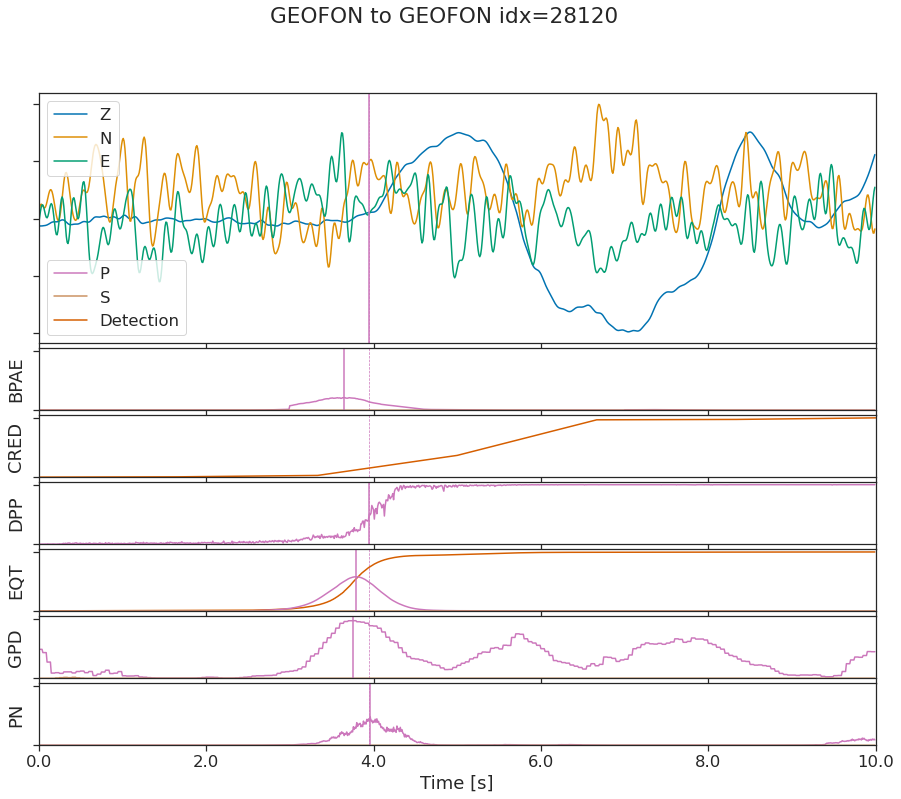

In [557]:
plot_example(28120);

In [558]:
plot_path = Path("example_plots/")

# GEOFON -> GEOFON
if True:
    fig = plot_example(28120)
    fig.savefig(plot_path / "geofon_geofon_28120.png", bbox_inches="tight")
    plt.close(fig)
# INSTANCE -> GEOFON
if False:
    fig = plot_example(28120)
    fig.savefig(plot_path / "instance_geofon_28120.png", bbox_inches="tight")
    plt.close(fig)
# INSTANCE -> INSTANCE
if False:
    fig = plot_example(67967, 2)
    fig.savefig(plot_path / "instance_instance_67967.png", bbox_inches="tight")
    plt.close(fig)
# ETHZ -> ETHZ
if False:
    fig = plot_example(3088)
    fig.savefig(plot_path / "ethz_ethz_3088.png", bbox_inches="tight")
    plt.close(fig)

In [349]:
# plot_path = Path("example_plots/")

# for i in range(10):
#     fig = plot_example()
#     fig.savefig(plot_path / f"{target}{i}.png", bbox_inches="tight")
#     plt.close(fig)

In [27]:
data_kwargs = dict(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")

geofon = sbd.GEOFON(**data_kwargs).dev()
ethz = sbd.ETHZ(**data_kwargs).dev()
instance = sbd.InstanceCounts(**data_kwargs).dev()

<ipython-input-27-f97720ba830a>:3: DtypeWarning: Columns (38,49,51) have mixed types.Specify dtype option on import or set low_memory=False.
  geofon = sbd.GEOFON(**data_kwargs).dev()
2021-08-16 12:20:50,582 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
<ipython-input-27-f97720ba830a>:4: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  ethz = sbd.ETHZ(**data_kwargs).dev()
<ipython-input-27-f97720ba830a>:5: DtypeWarning: Columns (23,24,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  instance = sbd.InstanceCounts(**data_kwargs).dev()


In [46]:
def gs_to_axs_sharex(fig, gs):
    axs = [fig.add_subplot(gs[0])]
    for i in range(1, 7):
        axs.append(fig.add_subplot(gs[i], sharex=axs[0]))
    return axs

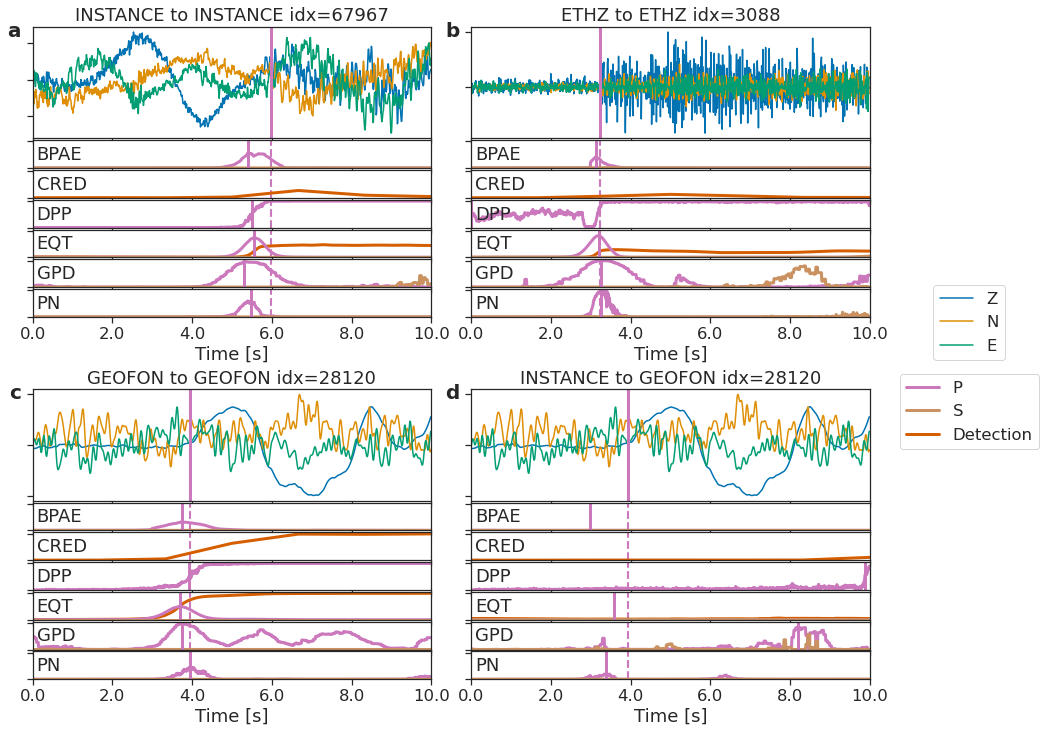

In [80]:
fig = plt.figure(figsize=(15, 12))
main_gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.25)

gs00 = main_gs[0, 0].subgridspec(7, 1, hspace=0.05, height_ratios=[4, 1, 1, 1, 1, 1, 1])
axs00 = gs_to_axs_sharex(fig, gs00)
gs01 = main_gs[0, 1].subgridspec(7, 1, hspace=0.05, height_ratios=[4, 1, 1, 1, 1, 1, 1])
axs01 = gs_to_axs_sharex(fig, gs01)
gs10 = main_gs[1, 0].subgridspec(7, 1, hspace=0.05, height_ratios=[4, 1, 1, 1, 1, 1, 1])
axs10 = gs_to_axs_sharex(fig, gs10)
gs11 = main_gs[1, 1].subgridspec(7, 1, hspace=0.05, height_ratios=[4, 1, 1, 1, 1, 1, 1])
axs11 = gs_to_axs_sharex(fig, gs11)

plots.comparison_plot("instance", "instance", instance, idx=67967, axs=axs00, legend=False)
plots.comparison_plot("ethz", "ethz", ethz, idx=3088, axs=axs01, legend=False)
plots.comparison_plot("geofon", "geofon", geofon, idx=28120, axs=axs10, legend=False)
_, zne_handles, psn_handles = plots.comparison_plot("instance", "geofon", geofon, idx=28120, axs=axs11, legend=False)

leg_zne = axs11[0].legend(handles=zne_handles, bbox_to_anchor=(1.25, 1.6), loc="center")
axs11[0].legend(handles=psn_handles, bbox_to_anchor=(1.25, 0.8), loc="center")
axs11[0].add_artist(leg_zne)

for axs in [axs00, axs01, axs10, axs11]:
    for ax in axs[1:]:
        ax.text(0.01, 0.8, ax.get_ylabel(), ha="left", va="top", transform=ax.transAxes)
        ax.set_ylabel("")

for i, axs in enumerate([axs00, axs01, axs10, axs11]):
    axs[0].text(-0.03, 1.05, f"{chr(97 + i)}", transform=axs[0].transAxes, va="top", ha="right",
                fontsize=20, fontweight="bold")

fig.savefig("predictions.png", bbox_inches="tight")